In [ ]:
import pandas as pd
from pyspark.sql import SparkSession

In [ ]:
spark = SparkSession.builder.appName("test").getOrCreate()

In [ ]:
df=spark.read.option("header",True).option("inferSchema",True).csv(r"/content/sample_data/application_data..csv")

In [ ]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[TARGET: int, NAME_CONTRACT_TYPE: string, CODE_GENDER: string, FLAG_OWN_CAR: string, FLAG_OWN_REALTY: string, CNT_CHILDREN: int, AMT_INCOME_TOTAL: double, AMT_CREDIT: double, AMT_ANNUITY: double, AMT_GOODS_PRICE: double, NAME_INCOME_TYPE: string, NAME_EDUCATION_TYPE: string, NAME_FAMILY_STATUS: string, NAME_HOUSING_TYPE: string, YEARS_BIRTH: int, YEARS_EMPLOYED: int, YEARS_REGISTRATION: int, OCCUPATION_TYPE: string, REGION_RATING_CLIENT_W_CITY: int, EXT_SOURCE_1: double, EXT_SOURCE_2: double, EXT_SOURCE_3: double, AMT_REQ_CREDIT_BUREAU_YEAR: int]>

In [ ]:
df.show(5,truncate=False)

+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-----------------------------+--------------------+-----------------+-----------+--------------+------------------+---------------+---------------------------+------------+------------+------------+--------------------------+
|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|CNT_CHILDREN|AMT_INCOME_TOTAL|AMT_CREDIT|AMT_ANNUITY|AMT_GOODS_PRICE|NAME_INCOME_TYPE|NAME_EDUCATION_TYPE          |NAME_FAMILY_STATUS  |NAME_HOUSING_TYPE|YEARS_BIRTH|YEARS_EMPLOYED|YEARS_REGISTRATION|OCCUPATION_TYPE|REGION_RATING_CLIENT_W_CITY|EXT_SOURCE_1|EXT_SOURCE_2|EXT_SOURCE_3|AMT_REQ_CREDIT_BUREAU_YEAR|
+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+----------------+-----------------------------+--------------------+-----------------+-----------+-----

In [ ]:
from pyspark.sql import functions as F
# bảng tóm lược dữ liệu:
df.summary().show()

+-------+-------------------+------------------+-----------+------------+---------------+------------------+------------------+------------------+------------------+-----------------+----------------+--------------------+------------------+-----------------+------------------+-----------------+------------------+---------------+---------------------------+-------------------+-------------------+-------------------+--------------------------+
|summary|             TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|      CNT_CHILDREN|  AMT_INCOME_TOTAL|        AMT_CREDIT|       AMT_ANNUITY|  AMT_GOODS_PRICE|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|       YEARS_BIRTH|   YEARS_EMPLOYED|YEARS_REGISTRATION|OCCUPATION_TYPE|REGION_RATING_CLIENT_W_CITY|       EXT_SOURCE_1|       EXT_SOURCE_2|       EXT_SOURCE_3|AMT_REQ_CREDIT_BUREAU_YEAR|
+-------+-------------------+------------------+-----------+------------+---------------+------------------+

In [ ]:
df = df.na.fill({"OCCUPATION_TYPE": "missing"})

In [ ]:

from pyspark.sql import functions as F

# Các biến cần xử lý
median_cols = [
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "AMT_REQ_CREDIT_BUREAU_YEAR"
]

# Tính median
median_dict = {
    c: df.approxQuantile(c, [0.5], 0.01)[0]
    for c in median_cols
}

# Fill missing
df = df.na.fill(median_dict)


In [ ]:
numeric_cols = [
    "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY",
    "AMT_GOODS_PRICE", "YEARS_BIRTH", "YEARS_EMPLOYED",
    "YEARS_REGISTRATION", "REGION_RATING_CLIENT_W_CITY",
    "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3",
    "AMT_REQ_CREDIT_BUREAU_YEAR"
]
from pyspark.sql.functions import skewness

skew_df = df.select([
    skewness(col).alias(col) for col in numeric_cols
])

skew_df.show(truncate=False)
skew_values = skew_df.collect()[0].asDict()

skew_result = [
    (col, skew_values[col]) for col in numeric_cols
]

skew_result


+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+------------------+---------------------------+--------------------+-------------------+-------------------+--------------------------+
|CNT_CHILDREN      |AMT_INCOME_TOTAL  |AMT_CREDIT        |AMT_ANNUITY      |AMT_GOODS_PRICE  |YEARS_BIRTH        |YEARS_EMPLOYED    |YEARS_REGISTRATION|REGION_RATING_CLIENT_W_CITY|EXT_SOURCE_1        |EXT_SOURCE_2       |EXT_SOURCE_3       |AMT_REQ_CREDIT_BUREAU_YEAR|
+------------------+------------------+------------------+-----------------+-----------------+-------------------+------------------+------------------+---------------------------+--------------------+-------------------+-------------------+--------------------------+
|1.9745948378093887|391.55774412286326|1.2347724740325132|1.579817123931705|1.350135963800553|0.11513379225723615|2.0394281275293182|0.5885781556227103|0.05972952079455577        |-0.0798696224

[('CNT_CHILDREN', 1.9745948378093887),
 ('AMT_INCOME_TOTAL', 391.55774412286326),
 ('AMT_CREDIT', 1.2347724740325132),
 ('AMT_ANNUITY', 1.579817123931705),
 ('AMT_GOODS_PRICE', 1.350135963800553),
 ('YEARS_BIRTH', 0.11513379225723615),
 ('YEARS_EMPLOYED', 2.0394281275293182),
 ('YEARS_REGISTRATION', 0.5885781556227103),
 ('REGION_RATING_CLIENT_W_CITY', 0.05972952079455577),
 ('EXT_SOURCE_1', -0.07986962241300023),
 ('EXT_SOURCE_2', -0.7959134419964284),
 ('EXT_SOURCE_3', -0.5320089296490708),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 1.4656360110141817)]

In [ ]:
from pyspark.sql.functions import log1p, col

log_cols = [
    "AMT_INCOME_TOTAL",
    "AMT_ANNUITY",
    "CNT_CHILDREN",
]

df_log = df

for c in log_cols:
    df_log = df_log.withColumn(c, log1p(col(c)))


In [ ]:
categorical_cols = [
    "NAME_CONTRACT_TYPE",
    "CODE_GENDER",
    "FLAG_OWN_CAR",
    "FLAG_OWN_REALTY",
    "NAME_INCOME_TYPE",
    "NAME_EDUCATION_TYPE",
    "NAME_FAMILY_STATUS",
    "NAME_HOUSING_TYPE",
    "OCCUPATION_TYPE"
]
numeric_cols = [
    "CNT_CHILDREN",
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "YEARS_BIRTH",
    "YEARS_EMPLOYED",
    "YEARS_REGISTRATION",
    "REGION_RATING_CLIENT_W_CITY",
    "EXT_SOURCE_1",
    "EXT_SOURCE_2",
    "EXT_SOURCE_3",
    "AMT_REQ_CREDIT_BUREAU_YEAR"
]


In [ ]:
from pyspark.ml.feature import StringIndexer

indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_idx",
        handleInvalid="keep"
    )
    for col in categorical_cols
]
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(
    inputCols=[f"{c}_idx" for c in categorical_cols],
    outputCols=[f"{c}_ohe" for c in categorical_cols]
)


In [ ]:
from pyspark.ml.feature import VectorAssembler

num_assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="num_features"
)
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="num_features",
    outputCol="num_scaled",
    withMean=False,
    withStd=True
)


In [ ]:
final_assembler = VectorAssembler(
    inputCols=[f"{c}_ohe" for c in categorical_cols] + ["num_scaled"],
    outputCol="features"
)
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=
    indexers +
    [encoder, num_assembler, scaler, final_assembler]
)

pipeline_model = pipeline.fit(df_log)
df_ready = pipeline_model.transform(df_log)
df_ready.select("features").show(5, truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                                                                                                                                                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(66,[0,3,

In [ ]:
df_ml = df_ready.select(
    col("TARGET").alias("label"),
    col("features")
)


In [ ]:
class_dist = df_ml.groupBy("label").count()
class_dist.show()


+-----+------+
|label| count|
+-----+------+
|    1| 24825|
|    0|282686|
+-----+------+



In [ ]:
total = df_ml.count()

weights = (
    class_dist
    .withColumn("weight", total / col("count"))
    .select("label", "weight")
)

df_ml = df_ml.join(weights, on="label", how="left")


In [ ]:
train_df, test_df = df_ml.randomSplit([0.7, 0.3], seed=42)


In [ ]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    weightCol="weight",
    maxIter=100,
    regParam=0.01,
    elasticNetParam=0.0     # L2
)

lr_model = lr.fit(train_df)


In [ ]:
pred = lr_model.transform(test_df)

pred.select(
    "label", "prediction", "probability"
).show(5, truncate=False)


+-----+----------+----------------------------------------+
|label|prediction|probability                             |
+-----+----------+----------------------------------------+
|0    |1.0       |[0.26444712371366086,0.7355528762863391]|
|0    |1.0       |[0.457435610202228,0.542564389797772]   |
|0    |1.0       |[0.19062027255093214,0.8093797274490678]|
|0    |0.0       |[0.6744064650500433,0.3255935349499567] |
|0    |0.0       |[0.5854838835669719,0.4145161164330281] |
+-----+----------+----------------------------------------+
only showing top 5 rows


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc_eval = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

auc = auc_eval.evaluate(pred)
print("AUC =", auc)
# accuracy
accuracy = (
    pred
    .filter(col("label") == col("prediction"))
    .count()
) / pred.count()

print("Accuracy =", accuracy)
#ma trận nhầm lẫn
confusion = (
    pred
    .groupBy("label", "prediction")
    .count()
    .orderBy("label", "prediction")
)

confusion.show()



AUC = 0.7416928442007653
Accuracy = 0.6825489813187529
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|57934|
|    0|       1.0|26839|
|    1|       0.0| 2423|
|    1|       1.0| 4982|
+-----+----------+-----+



In [ ]:
tp = pred.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = pred.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = pred.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = pred.filter((col("label") == 1) & (col("prediction") == 0)).count()

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * precision * recall / (precision + recall)

print("Precision =", precision)
print("Recall    =", recall)
print("F1-score  =", f1)
spark.createDataFrame([
    ("precision", precision),
    ("recall", recall),
    ("f1-score", f1),
    ("accuracy", accuracy),
    ("auc", auc)
], ["metric", "value"]).show()


Precision = 0.15656327582414128
Recall    = 0.6727886563133019
F1-score  = 0.25401519400397693
+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|precision|0.15656327582414128|
|   recall| 0.6727886563133019|
| f1-score|0.25401519400397693|
| accuracy| 0.6825489813187529|
|      auc| 0.7416928442007653|
+---------+-------------------+



In [ ]:
tp = pred.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = pred.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = pred.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = pred.filter((col("label") == 1) & (col("prediction") == 0)).count()

precision_1 = tp / (tp + fp)
recall_1 = tp / (tp + fn)
f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1)
support_1 = tp + fn

precision_0 = tn / (tn + fn)
recall_0 = tn / (tn + fp)
f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0)
support_0 = tn + fp

report_df = spark.createDataFrame([
    ("0 (Non-default)", precision_0, recall_0, f1_0, support_0),
    ("1 (Default)",     precision_1, recall_1, f1_1, support_1)
], ["Class", "Precision", "Recall", "F1-score", "Support"])

report_df.show(truncate=False)


+---------------+-------------------+------------------+-------------------+-------+
|Class          |Precision          |Recall            |F1-score           |Support|
+---------------+-------------------+------------------+-------------------+-------+
|0 (Non-default)|0.9598555262852693 |0.6834015547403065|0.7983738717012334 |84773  |
|1 (Default)    |0.15656327582414128|0.6727886563133019|0.25401519400397693|7405   |
+---------------+-------------------+------------------+-------------------+-------+



In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = (
    ParamGridBuilder()
    .addGrid(lr.regParam, [0.01, 0.1])
    .addGrid(lr.elasticNetParam, [0.0, 0.5])
    .build()
)

cv = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid,
    evaluator=auc_eval,
    numFolds=5
)

cv_model = cv.fit(train_df)

cv_pred = cv_model.transform(test_df)
print("CV AUC =", auc_eval.evaluate(cv_pred))

NameError: name 'lr' is not defined

In [ ]:
roc_df = lr_model.summary.roc
roc_df.show(5)
roc_pd = roc_df.toPandas()


+--------------------+--------------------+
|                 FPR|                 TPR|
+--------------------+--------------------+
|                 0.0|                 0.0|
|5.557997706062766E-4|0.006027554535017222|
|0.001131810441961...|0.011825487944890932|
|0.001738137464441...|0.017278989667049376|
|0.002293937235047...|0.023306544202066595|
+--------------------+--------------------+
only showing top 5 rows


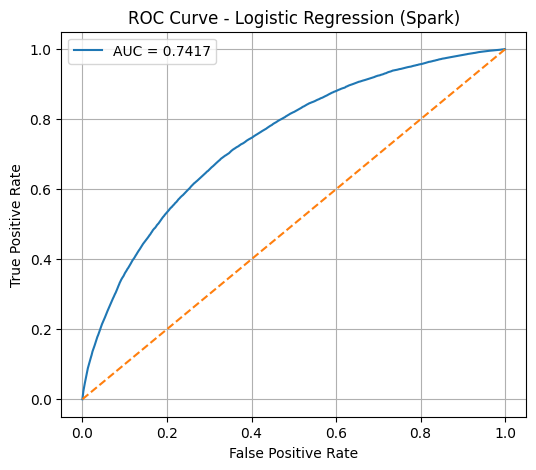

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(roc_pd["FPR"], roc_pd["TPR"], label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression (Spark)")
plt.legend()
plt.grid(True)
plt.show()
